# Crop Yield Prediction - Deep Learning

Use NUTS3 input data to produce NUTS3 crop yield forecasts. Aggregate forecasts to NUTS2 level and train model using weak supervision from NUTS2 yield statistics.

In [ ]:
test_env = 'guanabana'

from d2l import torch as d2l
import numpy as np
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import functions as SparkF
from pyspark.sql import types as SparkT

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

spark = SparkSession.builder.master("local[25]")\
                            .config("spark.driver.memory", "24g")\
                            .config("spark.driver.maxResultSize", "6g")\
                            .config("spark.executor.memory", "24g")\
                            .config("spark.network.timeout", "800s")\
                            .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

# crop name to id mapping
crop_id_dict = {
    'grain maize': 2,
    'sugar beet' : 6,
    'sugarbeet' : 6,
    'sugarbeets' : 6,
    'sugar beets' : 6,
    'total potatoes' : 7,
    'potatoes' : 7,
    'potato' : 7,
    'winter wheat' : 90,
    'soft wheat' : 90,
    'sunflower' : 93,
    'spring barley' : 95,
}

# crop id to name mapping
crop_name_dict = {
    2 : 'grain maize',
    6 : 'sugarbeet',
    7 : 'potatoes',
    90 : 'soft wheat',
    93 : 'sunflower',
    95 : 'spring barley',
}

## Utility Functions

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error

from pyspark.sql import Window

# crop name and id mappings
def cropNameToID(crop_id_dict, crop):
  """
  Return id of given crop. Relies on crop_id_dict.
  Return 0 if crop name is not in the dictionary.
  """
  crop_lcase = crop.lower()
  try:
    crop_id = crop_id_dict[crop_lcase]
  except KeyError as e:
    crop_id = 0

  return crop_id

def cropIDToName(crop_name_dict, crop_id):
  """
  Return crop name for given crop ID. Relies on crop_name_dict.
  Return 'NA' if crop id is not found in the dictionary.
  """
  try:
    crop_name = crop_name_dict[crop_id]
  except KeyError as e:
    crop_name = 'NA'

  return crop_name

def getYear(date_str):
  """Extract year from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.year(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.year(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getMonth(date_str):
  """Extract month from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.month(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.month(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getDay(date_str):
  """Extract day from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.dayofmonth(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.dayofmonth(SparkF.to_date(date_str, 'dd/MM/yyyy')))

# 1-10: Dekad 1
# 11-20: Dekad 2
# > 20 : Dekad 3
def getDekad(date_str):
  """Extract dekad from date in YYYYMMDD format."""
  month = getMonth(date_str)
  day = getDay(date_str)
  return SparkF.when(day < 30, (month - 1)* 3 +
                     SparkF.ceil(day/10)).otherwise((month - 1) * 3 + 3)

def getFilename(crop, yield_trend, early_season_end,
                country=None, spatial_level=None, architecture=None):
  """Get filename based on input arguments"""
  suffix = crop.replace(' ', '_')

  if (country is not None):
    suffix += '_' + country

  if (spatial_level is not None):
    suffix += '_' + spatial_level

  if (yield_trend):
    suffix += '_trend'
  else:
    suffix += '_notrend'

  if (early_season_end < 0):
    suffix += '_early' + str(early_season_end)

  if (architecture is not None):
    suffix += '-' + architecture

  return suffix

def getLogFilename(crop, yield_trend, early_season_end,
                   country=None, architecture=None):
  """Get filename for experiment log"""
  log_file = getFilename(crop, yield_trend, early_season_end,
                         country=country,
                         architecture=architecture)
  return log_file + '.log'

def getPredictionFilename(crop, yield_trend, early_season_end,
                          country=None, spatial_level=None, architecture=None):
  """Get unique filename for predictions"""
  pred_file = 'pred_'
  suffix = getFilename(crop, yield_trend, early_season_end,
                       country=country,
                       spatial_level=spatial_level,
                       architecture=architecture)
  pred_file += suffix
  return pred_file

def printConfig(cyp_config, log_fh=None):
  config_str = '\nCurrent DL Configuration'
  config_str += '\n-------------------------'
  for k in cyp_config:
    conf_val = cyp_config[k]
    if (not isinstance(conf_val, str)):
      conf_val = str(conf_val)

    config_str += '\n' + k + ': ' + conf_val
  
  config_str += '\n'
  if (log_fh is not None):
    log_fh.write(config_str)

  print(config_str)

def printPreprocessingInformation(df, data_source, id_cols,
                                  order_cols, crop_season=None):
  """Print preprocessed data and additional debug information"""
  df_regions = [reg[0] for reg in df.select(id_cols).distinct().collect()]
  print(data_source , 'data available for', len(df_regions), 'region(s)')
  if (crop_season is not None):
    print('Season end information')
    crop_season.orderBy(id_cols + ['FYEAR']).show(10)

  print(data_source, 'data')
  df.orderBy(order_cols).show(10)

def getTrendWindowYields(df, id_col, trend_window):
  """Extract previous years' yield values to separate columns"""
  sel_cols = [id_col, 'FYEAR', 'YIELD']
  my_window = Window.partitionBy(id_col).orderBy('FYEAR')

  yield_fts = df.select(sel_cols)
  for i in range(trend_window):
    yield_fts = yield_fts.withColumn('YIELD-' + str(i+1),
                                     SparkF.lag(yield_fts.YIELD, i+1).over(my_window))
    yield_fts = yield_fts.withColumn('YEAR-' + str(i+1),
                                     SparkF.lag(yield_fts.FYEAR, i+1).over(my_window))

  # drop columns withs null values
  for i in range(trend_window):
    yield_fts = yield_fts.filter(SparkF.col('YIELD-' + str(i+1)).isNotNull())

  prev_yields = [ 'YIELD-' + str(i) for i in range(trend_window, 0, -1)]
  prev_years = [ 'YEAR-' + str(i) for i in range(trend_window, 0, -1)]
  sel_cols = [id_col, 'FYEAR'] + prev_years + prev_yields
  yield_fts = yield_fts.select(sel_cols)

  return yield_fts

def getNumericIDS(src_df, sel_col, num_id_col):
  """Assigns monotonically increasing unique ids to selected col values"""
  id_df = src_df.select(sel_col).distinct().orderBy(sel_col)
  id_df = id_df.withColumn(num_id_col, SparkF.monotonically_increasing_id())

  return id_df

def NormalizedRMSE(y_true, y_pred):
  y_true = y_true.astype('float64')
  y_pred = y_pred.astype('float64')
  return 100 * np.sqrt(mean_squared_error(y_true, y_pred))/np.mean(y_true)

## Data Preprocessor Class

In [ ]:
from pyspark.sql import Window

class CYPDataPreprocessor:
  def __init__(self, spark):
    self.spark = spark
    self.verbose = 1

  def extractYearDekad(self, df):
    """Extract year and dekad from date_col in yyyyMMdd format."""
    # Conversion to string type is required to make getYear(), getMonth() etc. work correctly.
    # They use to_date() function to verify valid dates and to_date() expects the date column to be string.
    df = df.withColumn('DATE', df['DATE'].cast("string"))
    df = df.select('*',
                   getYear('DATE').alias('FYEAR'),
                   getDekad('DATE').alias('DEKAD'))

    # Bring FYEAR, DEKAD to the front
    col_order = df.columns[:2] + df.columns[-2:] + df.columns[2:-2]
    df = df.select(col_order).drop('DATE')
    return df

  def preprocessCSSF(self, cssf_df):
    cssf_df = cssf_df.withColumnRenamed('year', 'FYEAR')
    cssf_df = cssf_df.withColumnRenamed('dekad', 'DEKAD')
    cssf_df = cssf_df.drop(*['LONTD', 'LATTD'])

    return cssf_df

  def preprocessMeteo(self, meteo_df):
    """
    Calculate CWB.
    """
    meteo_df = meteo_df.withColumn('CWB',
                                   SparkF.bround(meteo_df['PREC'] - meteo_df['ET0'], 2))

    meteo_df = meteo_df.withColumnRenamed('year', 'FYEAR')
    meteo_df = meteo_df.withColumnRenamed('dekad', 'DEKAD')
    meteo_df = meteo_df.drop(*['LONTD', 'LATTD'])

    return meteo_df

  def preprocessRemoteSensing(self, rs_df):
    rs_df = rs_df.withColumnRenamed('year', 'FYEAR')
    rs_df = rs_df.withColumnRenamed('dekad', 'DEKAD')
    rs_df = rs_df.drop(*['LONTD', 'LATTD'])

    return rs_df

  def preprocessCropArea(self, area_df):
    area_df = area_df.withColumn("FYEAR", area_df["FYEAR"].cast(SparkT.IntegerType()))
    area_df = area_df.filter(area_df["CROP_AREA"].isNotNull())
    # convert crop area into ha
    area_df = area_df.withColumn('CROP_AREA', SparkF.round(area_df['CROP_AREA'] * 0.404686, 3))

    return area_df

  def preprocessYield(self, yield_df, spatial_level='GRIDS'):
    """
    Convert county yields to t/ha.
    See https://www.ndwheat.com/buyers/chartsandstats/
    """
    if (spatial_level == 'COUNTY'):
      yield_df = yield_df.withColumn('YIELD', SparkF.round(yield_df['YIELD'] * 0.06725, 3))

    yield_df = yield_df.withColumn("FYEAR", yield_df["FYEAR"].cast(SparkT.IntegerType()))
    yield_df = yield_df.filter(yield_df['YIELD'] > 0.0)
    return yield_df

## Data Loading and Preprocessing

In [ ]:
from datetime import date

def loadDataFromCSVFile(spark, data_path, src, spatial_level, country_code):
    """
    The implied filename for each source is:
    <data_source>_<spatial_level>_<country_code>.csv
    Examples: WOFOST_NUTS2_NL.csv.
    Schema is inferred from the file. We might want to specify the schema at some point.
    """
    if (country_code is not None):
      datafile = data_path + '/' + src  + '_' + spatial_level + '_' + country_code + '.csv'
    elif (spatial_level is not None):
      datafile = data_path + '/' + src  + '_' + spatial_level + '.csv'
    else:
      datafile = data_path + '/' + src  + '.csv'

    print('Data file name', '"' + datafile + '"')

    df = spark.read.csv(datafile, header = True, inferSchema = True)
    return df

def loadAllData(spark, data_sources, data_path='.', country=None):
  #################
  # Load data     #
  #################
  data_dfs = {}
  for src in data_sources:
    spatial_level = data_sources[src]['spatial_level']
    data_dfs[src] = loadDataFromCSVFile(spark, data_path, src, spatial_level, country)

  data_sources_str = ''
  for src in data_dfs:
    data_sources_str = data_sources_str + src + ', '

  # remove the comma and space from the end
  print('Loaded data:', data_sources_str[:-2])
  print('\n')

  return data_dfs

def preprocessData(spark, data_dfs, data_sources,
                   crop, season_crosses_calyear=False,
                   early_season=False, early_season_end=0, print_debug=False):
  ######################
  # Preprocess Data    #
  ######################
  cyp_preprocessor = CYPDataPreprocessor(spark)
  crop_season = None

  # county_grids_df = data_dfs['COUNTY']
  # w = Window.partitionBy('GRID_ID')
  # county_grids_df = county_grids_df.withColumn('maxSHAPE_AREA', SparkF.max('TOTAL_AREA').over(w))
  # county_grids_df = county_grids_df.filter(county_grids_df['TOTAL_AREA'] == county_grids_df['maxSHAPE_AREA'])
  # county_grids_df = county_grids_df.drop(*['maxSHAPE_AREA', 'TOTAL_AREA'])
  # # ['AR', 'MO', 'TN', 'KY', 'IL', 'IN', 'KS', 'OH', 'NE', 'IA', 'PA', 'MI', 'WI', 'SD', 'MN', 'ND']
  # county_grids_df = county_grids_df.filter(SparkF.substring(county_grids_df['COUNTY_ID'], 1, 2) == 'IA')

  for src in data_sources:
    sel_cols = data_sources[src]['sel_cols']
    spatial_level = data_sources[src]['spatial_level']
    if ('GRID_ID' in sel_cols):
      src_df = data_dfs[src] #.join(county_grids_df, ['GRID_ID']).drop('COUNTY_ID')
    else:
      src_df = data_dfs[src]

    # crop productivity data (CSSF)
    if (src == 'CSSF'):
      cssf_df = cyp_preprocessor.preprocessCSSF(src_df)
      assert (cssf_df is not None)
      data_dfs[src] = cssf_df.select(sel_cols)

    # meteo data
    if ('METEO' in src):
      meteo_df = cyp_preprocessor.preprocessMeteo(src_df)

      assert (meteo_df is not None)
      data_dfs[src] = meteo_df.select(sel_cols)

    # remote sensing data
    if (src == 'REMOTE_SENSING'):
      rs_df = cyp_preprocessor.preprocessRemoteSensing(src_df)
      assert (rs_df is not None)
      data_dfs[src] = rs_df.select(sel_cols)

    # soil data
    if (src == 'SOIL'):
      data_dfs['SOIL'] = src_df.select(sel_cols)

    # crop area data
    if (src == 'CROP_AREA'):
      crop_area_df = cyp_preprocessor.preprocessCropArea(src_df)
      data_dfs['CROP_AREA'] = crop_area_df.select(sel_cols)

    # label data
    if (src == 'YIELD'):
      yield_df = cyp_preprocessor.preprocessYield(src_df,
                                                  spatial_level=spatial_level)
      data_dfs['YIELD'] = yield_df.select(sel_cols)

  # Print debug information
  for src in data_dfs:
    src_df = data_dfs[src]
    order_cols = data_sources[src]['order_cols']
    if ('GRID_ID' in src_df.columns):
      printPreprocessingInformation(src_df, src, ['GRID_ID'], order_cols)
    elif (print_debug):
      printPreprocessingInformation(src_df, src, ['COUNTY_ID'], order_cols)

  return data_dfs

def getLinearYieldTrend(pd_yield_ft_df, id_cols, trend_window):
  """Fits a linear trend model to yields from 5 previous years"""
  join_cols = id_cols + ['FYEAR']
  region_years = pd_yield_ft_df[join_cols].values
  prev_year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  prev_yield_cols = ['YIELD-' + str(i) for i in range(1, trend_window + 1)]
  window_years = pd_yield_ft_df[prev_year_cols].values
  window_yields = pd_yield_ft_df[prev_yield_cols].values

  yield_trend = []
  for i in range(region_years.shape[0]):
    coefs = np.polyfit(window_years[i, :], window_yields[i, :], 1)
    yield_trend.append(float(np.round(coefs[0] * region_years[i, 1] + coefs[1], 2)))

  pd_yield_ft_df['YIELD_TREND'] = yield_trend
  drop_cols = ['YEAR-' + str(i) for i in range(1, 6)]
  pd_yield_ft_df = pd_yield_ft_df.drop(columns=drop_cols)

  return pd_yield_ft_df

def combineInputData(data_sources, data_dfs,
                     ts_data_sources,
                     static_data_sources,
                     high_res_id_col, low_res_id_col,
                     trend_window=5,
                     early_season_end=None,
                     print_debug=False):
  """Combine dekadal and static data"""
  input_min_year = 1900
  input_max_year = date.today().year
  for src in ts_data_sources:
    input_df = data_dfs[src]
    min_year = input_df.agg(SparkF.min('FYEAR')).collect()[0][0]
    max_year = input_df.agg(SparkF.max('FYEAR')).collect()[0][0]
    # max of min years (earliest year after join, not min of min)
    if (min_year > input_min_year):
      input_min_year = min_year
    # min of max years (latest year after join, not max of max)
    if (max_year < input_max_year):
      input_max_year = max_year

  # combine dekadal data
  dekadal_df = None
  for src in ts_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    input_df = input_df.filter((input_df['FYEAR'] >= input_min_year) &
                               (input_df['FYEAR'] <= input_max_year))
    if (dekadal_df is None):
      dekadal_df = input_df
    else:
      dekadal_df = dekadal_df.join(input_df, data_sources[src]['order_cols'], 'full')
      dekadal_df = dekadal_df.na.fill(0.0)

  max_dekad = 36
  if (early_season_end is not None):
    # early_season_end is relative to harvest (so 0 or negative)
    max_dekad += early_season_end
    dekadal_df = dekadal_df.filter(dekadal_df['DEKAD'] <= max_dekad)

  county_grids_df = data_dfs['COUNTY']
  dekadal_cols = dekadal_df.columns
  dekadal_df = dekadal_df.join(county_grids_df.select([low_res_id_col, high_res_id_col]),
                                                      [high_res_id_col])
  dekadal_df = dekadal_df.select([low_res_id_col] + dekadal_cols)

  static_df = None
  for src in static_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    if (static_df is None):
      static_df = input_df
    else:
      static_df = static_df.join(input_df, data_sources[src]['order_cols'])

  static_cols = static_df.columns
  static_df = static_df.na.drop()
  static_df = static_df.join(county_grids_df.select([low_res_id_col, high_res_id_col]),
                                                    [high_res_id_col])
  static_df = static_df.select([low_res_id_col] + static_cols)

  label_df = data_dfs['YIELD']
  crop_area_df = data_dfs['CROP_AREA']

  # get trend feature values: basically values of 5 previous years
  trend_ft_df = getTrendWindowYields(label_df, low_res_id_col, trend_window)
  year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  trend_ft_df = trend_ft_df.drop(*year_cols)

  # Training, test splits are decided based on label years.
  country_years = sorted([yr[0] for yr in label_df.select('FYEAR').distinct().collect()])

  # Align spatial units and years
  label_df = label_df.join(static_df.select(low_res_id_col).distinct(), [low_res_id_col])
  label_df = label_df.join(trend_ft_df.select([low_res_id_col, 'FYEAR']),
                           [low_res_id_col, 'FYEAR'])
  # NOTE: CROP_AREA is added to label_df
  label_df = label_df.join(crop_area_df, [low_res_id_col, 'FYEAR'])
  label_df = label_df.join(dekadal_df.select([low_res_id_col, 'FYEAR']).distinct(),
                           [low_res_id_col, 'FYEAR'])
  label_reg_years = label_df.select([low_res_id_col, 'FYEAR']).distinct()
  trend_ft_df = trend_ft_df.join(label_reg_years, [low_res_id_col, 'FYEAR'])
  dekadal_df = dekadal_df.join(label_reg_years, [low_res_id_col, 'FYEAR'])
  label_regions = label_df.select(low_res_id_col).distinct()
  static_df = static_df.join(label_regions, [low_res_id_col])
  county_grids_df = county_grids_df.join(label_regions, [low_res_id_col])

  # Create numeric ids for counties
  label_id_df = getNumericIDS(label_df, low_res_id_col, 'id_y')
  input_id_df = county_grids_df.join(label_id_df, ['COUNTY_ID']).drop('TOTAL_AREA')

  # Add numeric id columns, remove id_col and reorder columns
  label_num_id_cols = ['id_y']
  label_join_cols = [low_res_id_col]
  label_drop_cols = [low_res_id_col]
  input_num_id_cols = ['id_y', high_res_id_col]
  input_join_cols = [low_res_id_col, high_res_id_col]
  input_drop_cols = [low_res_id_col]

  # Add numeric id columns : DEKADAL
  dekadal_df = dekadal_df.join(input_id_df, input_join_cols).drop(*input_drop_cols)
  dekadal_df = dekadal_df.select(input_num_id_cols + 
                                 [c for c in dekadal_df.columns if c not in input_num_id_cols])
  if (print_debug):
    print('\n')
    print('DEKADAL')
    dekadal_df.orderBy(input_num_id_cols + ['FYEAR', 'DEKAD']).show(10)

  # Add numeric id columns : TREND
  trend_ft_df = trend_ft_df.join(label_id_df, label_join_cols).drop(*label_drop_cols)
  trend_ft_df = trend_ft_df.select(label_num_id_cols +
                                   [c for c in trend_ft_df.columns if c not in label_num_id_cols])
  if (print_debug):
    print('\n')
    print('TREND')
    trend_ft_df.orderBy(label_num_id_cols + ['FYEAR']).show(10)

  # Add numeric id columns : YIELD
  label_df = label_df.join(label_id_df, label_join_cols).drop(*label_drop_cols)
  label_df = label_df.select(label_num_id_cols +
                             [c for c in label_df.columns if c not in label_num_id_cols])
  if (print_debug):
    print('\n')
    print('YIELD')
    label_df.orderBy(label_num_id_cols + ['FYEAR']).show(10)

  # Add numeric id columns : STATIC
  # NOTE TOTAL_AREA comes from county_grids_df
  static_df = static_df.join(county_grids_df, input_join_cols)
  static_df = static_df.join(input_id_df, input_join_cols).drop(*input_drop_cols)
  static_df = static_df.select(input_num_id_cols +
                               [c for c in static_df.columns if c not in input_num_id_cols])
  if (print_debug):
    print('\n')
    print('STATIC')
    static_df.orderBy(input_num_id_cols).show(10)

  if (print_debug):
    print('\n')
    print('NUMERIC_IDS')
    input_id_df.orderBy(input_num_id_cols).show(10)
    label_id_df.orderBy(label_num_id_cols).show(10)

  combined_dfs = {
      'DEKADAL' : dekadal_df.toPandas(),
      'STATIC' : static_df.toPandas(),
      'YIELD_TREND' : trend_ft_df.toPandas(),
      'YIELD' : label_df.toPandas(),
      'LABEL_NUMERIC_IDS' : label_id_df.toPandas(),
      'INPUT_NUMERIC_IDS' : input_id_df.toPandas(),
  }

  return combined_dfs, country_years

## Training, Validation and Test Splits

In [ ]:
import numpy as np

class CYPTrainTestSplitter:
  def __init__(self, verbose=False):
    self.verbose = verbose

  def getTestYears(self, all_years, test_fraction=None, use_yield_trend=None):
    num_years = len(all_years)
    test_years = []
    if (test_fraction is None):
      test_fraction = self.test_fraction

    if (use_yield_trend is None):
      use_yield_trend = self.use_yield_trend

    if (use_yield_trend):
      # If test_year_start 15, years with index >= 15 are added to the test set
      test_year_start = num_years - np.floor(num_years * test_fraction).astype('int')
      test_years = all_years[test_year_start:]
    else:
      # If test_year_pos = 5, every 5th year is added to test set.
      # indices start with 0, so test_year_pos'th year has index (test_year_pos - 1)
      test_year_pos = np.floor(1/test_fraction).astype('int')
      test_years = all_years[test_year_pos - 1::test_year_pos]

    return test_years

  # NOTE Y_train should include region_id, FYEAR as first two columns.
  def getCustomKFoldValidationYears(self, all_years, num_folds=5, num_valid_years=1):
    """
    Custom K-fold Validation Splits:
    When using yield trend, we cannot do k-fold cross-validation. The custom
    K-Fold validation splits data in time-ordered fashion. The test data
    always comes after the training data.
    """
    num_years = len(all_years)
    num_train_years = num_years - (num_valid_years * num_folds)

    custom_split_info = '\nCustom sliding validation train, test splits'
    custom_split_info += '\n----------------------------------------------'

    cv_valid_years = []
    for k in range(num_folds):
      test_years_start = num_train_years + (k * num_valid_years)
      k_train_years = all_years[:test_years_start]
      k_val_years = all_years[test_years_start:test_years_start + num_valid_years]
      cv_valid_years.append(k_val_years)
      k_train_years = [str(y) for y in k_train_years]
      k_val_years = [str(y) for y in k_val_years]
      custom_split_info += '\nValidation set ' + str(k + 1) + ' training years: ' + ', '.join(k_train_years)
      custom_split_info += '\nValidation set ' + str(k + 1) + ' test years: ' + ', '.join(k_val_years)

    custom_split_info += '\n'
    if (self.verbose):
      print(custom_split_info)

    return cv_valid_years

## Dataset Class

In [ ]:
from torch.utils.data import Dataset

# A dataset class for crop yield forecasting data
# A dataset class for crop yield forecasting data
class CYPMLDataset(Dataset):
  """
  Dataset class used to load features and labels for training and testing.
  For more info about writing custom datasets classes check
  https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

  Parameters
  ----------
  data_dfs : dictionary of input dataframes
  yield_trend : data uses yield trend
  early_season_end : early season prediction dekad (relative to harvest)
  is_train : bool to differentiate training, validation and test sets
  is_validation : bool to differentiate between training and validation sets
  test_fraction : fraction of years to use for held-out testing
  num_folds : number of folds for custom cv
  num_valid_years : number of years in validation set
  fold_iter : iteration number of cv
  scaler_args : mean, std values (for each indicator) calculated using training dataset
  """
  def __init__(self, data_dfs, country_years,
               yield_trend=True, early_season_end=None,
               is_train=True, is_validation=False, test_fraction=0.3,
               num_folds=1, num_valid_years=5, fold_iter=0,
               scaler_args=None,
               print_debug=False, log_fh=None):

    if (is_train and print_debug):
      print('\n----------------')
      print('Training data')
      print('----------------')
    elif (is_validation and print_debug):
      print('\n------------------')
      print('Validation data')
      print('------------------')
    elif (print_debug):
      print('\n-------------')
      print('Test data:')
      print('-------------')

    pd_dekadal_df = data_dfs['DEKADAL']
    max_dekad = 36
    if (early_season_end is not None):
      # early_season_end is relative to harvest (so 0 or negative)
      max_dekad += early_season_end

    pd_label_df = data_dfs['YIELD']
    pd_trend_df = data_dfs['YIELD_TREND']
    pd_static_df = data_dfs['STATIC']

    # Static data
    static_excl_cols = [ 'id_y', 'GRID_ID', 'TOTAL_AREA' ]
    static_feature_cols = [ c for c in pd_static_df.columns if c not in static_excl_cols]
    static_sel_cols =  static_excl_cols + static_feature_cols

    # Dekadal data should have id_y, GRID_ID, FYEAR, DEKAD, ...
    dekadal_feature_cols = list(pd_dekadal_df.columns.values)[4:]
    self.dekadal_feature_cols = dekadal_feature_cols
    max_dekad = 36
    if (early_season_end is not None):
      # early_season_end is relative to harvest (so 0 or negative)
      max_dekad += early_season_end

    self.max_dekad = max_dekad
    # Trend data should have id_y, FYEAR, ...
    trend_feature_cols = list(pd_trend_df.columns.values)[2:]
    # For labels, we want to keep all columns. CROP_AREA is included in pd_label_df
    label_cols = list(pd_label_df.columns.values)

    if (print_debug):
      assert (log_fh is not None)
      feature_cols_info = '\n'
      feature_cols_info += '\nDekadal features: ' + ', '.join(dekadal_feature_cols)
      feature_cols_info += '\nOther features: ' + ', '.join(static_feature_cols)
      feature_cols_info += '\nTrend features: ' + ', '.join(trend_feature_cols)
      feature_cols_info += '\nLabel columns: ' + ', '.join(label_cols[2:])
      print(feature_cols_info)
      log_fh.write(feature_cols_info + '\n')

    self.input_id_df = data_dfs['INPUT_NUMERIC_IDS']
    # in the baseline, test years are determined based on all years available.
    select_years = self.selectYears(country_years, is_train, is_validation, test_fraction,
                                    num_folds, num_valid_years, fold_iter,
                                    yield_trend)

    min_trend_year = pd_trend_df['FYEAR'].min()
    min_dek_year = pd_dekadal_df['FYEAR'].min()
    select_years = [int(yr) for yr in select_years]
    # In case of training, filter earlier years not in other data.
    if (is_train):
      select_years = [ yr for yr in select_years if ((yr >= min_trend_year) and (yr >= min_dek_year))]

    if (is_train and print_debug):
      train_info = '\n Training years: ' + ', '.join([str(yr) for yr in select_years])
      log_fh.write(train_info + '\n')
      print(train_info)
    elif (is_validation and print_debug):
      valid_info = '\n Validation years: ' + ', '.join([str(yr) for yr in select_years])
      log_fh.write(valid_info + '\n')
      print(valid_info)
    elif (print_debug):
      test_info = '\n Test years: ' + ', '.join([str(yr) for yr in select_years])
      log_fh.write(test_info + '\n')
      print(test_info)

    pd_label_df = pd_label_df[pd_label_df['FYEAR'].isin(select_years)]
    self.Y = pd_label_df[label_cols].values
    self.pd_trend_df = pd_trend_df[pd_trend_df['FYEAR'].isin(select_years)]
    self.pd_dekadal_df = pd_dekadal_df[pd_dekadal_df['FYEAR'].isin(select_years)]
    self.pd_static_df = pd_static_df[static_sel_cols]

    # Normalize data
    if (is_train and (scaler_args is not None)):
      for dek_col in dekadal_feature_cols:
        scaler_args[dek_col] = [self.pd_dekadal_df[dek_col].mean(), self.pd_dekadal_df[dek_col].std()]

      for trend_col in trend_feature_cols:
        scaler_args[trend_col] = [self.pd_trend_df[trend_col].mean(), self.pd_trend_df[trend_col].std()]

      for st_col in static_feature_cols:
        scaler_args[st_col] = [self.pd_static_df[st_col].mean(), self.pd_static_df[st_col].std()]

    if (scaler_args is not None):
      for dek_col in dekadal_feature_cols:
        avg_val, std_val = scaler_args[dek_col][0], scaler_args[dek_col][1]
        self.pd_dekadal_df[dek_col] = (self.pd_dekadal_df[dek_col] - avg_val)/std_val

      for trend_col in trend_feature_cols:
        avg_val, std_val = scaler_args[trend_col][0], scaler_args[trend_col][1]
        self.pd_trend_df[trend_col] = (self.pd_trend_df[trend_col] - avg_val)/std_val

      for st_col in static_feature_cols:
        avg_val, std_val = scaler_args[st_col][0], scaler_args[st_col][1]
        self.pd_static_df[st_col] = (self.pd_static_df[st_col] - avg_val)/std_val

    # create pivot tables
    self.pd_dekadal_df = self.pd_dekadal_df.pivot_table(values=dekadal_feature_cols,
                                                        index=["id_y", "GRID_ID", "FYEAR"],
                                                        columns=["DEKAD"],
                                                        fill_value=0.0)
    self.pd_trend_df = self.pd_trend_df.pivot_table(values=trend_feature_cols,
                                                    index=["id_y", "FYEAR"],
                                                    fill_value=0.0)
    self.pd_total_area_df = self.pd_static_df.pivot_table(values=['TOTAL_AREA'],
                                                      index=["id_y", "GRID_ID"],
                                                      fill_value=0.0)
    self.pd_static_df = self.pd_static_df.pivot_table(values=static_feature_cols,
                                                      index=["id_y", "GRID_ID"],
                                                      fill_value=0.0)

    if ((self.Y is not None) and print_debug):
      data_info = '\n'
      dekadal_data_shape = [len(self.pd_dekadal_df.index), max_dekad, len(dekadal_feature_cols)]
      trend_data_shape = [len(self.pd_trend_df.index), len(trend_feature_cols)]
      static_data_shape = [len(self.pd_static_df.index), len(static_feature_cols)]
      data_info += '\nDekadal data: ' + ', '.join([ str(x) for x in dekadal_data_shape])
      data_info += '\nOther feature data: ' + ', '.join([ str(x) for x in static_data_shape])
      data_info += '\nTrend feature data: ' + ', '.join([ str(x) for x in trend_data_shape])
      data_info += '\nLabel data: ' + ', '.join([ str(x) for x in self.Y.shape ])
      print(data_info)
      log_fh.write(data_info + '\n')

  def selectYears(self, all_years, is_train, is_validation, test_fraction,
                  num_folds, num_valid_years, fold_iter,
                  yield_trend=True):
    """Get selected train OR validation OR test years"""
    trts_splitter = CYPTrainTestSplitter()
    test_years = trts_splitter.getTestYears(all_years, test_fraction=test_fraction,
                                            use_yield_trend=yield_trend)

    if ((not is_train) and (not is_validation)):
      return test_years

    train_years = [yr for yr in all_years if yr not in test_years]
    if (num_valid_years == 0):
      return train_years

    custom_valid_years = trts_splitter.getCustomKFoldValidationYears(train_years,
                                                                     num_folds=num_folds,
                                                                     num_valid_years=num_valid_years)
    validation_years = custom_valid_years[fold_iter]
    train_years = [yr for yr in train_years if yr < validation_years[0]]
    select_years = train_years if is_train else validation_years

    return select_years

  def getAverageValue(self, indicator='YIELD'):
    # self.Y has YIELD, CROP_AREA at the end
    if (indicator == 'YIELD'):
      return torch.from_numpy(np.array(np.mean(self.Y[:, -2]), dtype='float64'))
    elif (indicator == 'CROP_AREA'):
      return torch.from_numpy(np.array(np.mean(self.Y[:, -1]), dtype='float64'))
    else:
      return torch.zeros(1)

  def getStaticFeatureCols(self):
    return self.static_feature_cols

  def __len__(self):
    if (self.Y is None):
      return 0

    return self.Y.shape[0]

  def __getitem__(self, idx):
    """
    Returns data for given idx, which selects a specific id_y and FYEAR
    sel_X_dek : Dekadal (time series) data
    sel_X_rest : Other feature data (mostly static)
    sel_X_trend : Trend features (yields of 5 previous years)
    sel_Y : Yield for given county and year
    sel_crop_area : crop area for given county and year
    sel_grid_ids : grids included in selected COUNTY_ID
    """
    assert (idx < self.Y.shape[0])
    sel_id_y = self.Y[idx, 0]
    sel_year = self.Y[idx, 1]
    sel_grid_ids = self.input_id_df[self.input_id_df['id_y'] == sel_id_y]['GRID_ID'].values
    sel_X_dekadal = None
    sel_X_static = None
    valid_gd_idxs = []
    for i, gd in enumerate(sel_grid_ids):
      try:
        X_dek = self.pd_dekadal_df.loc[(sel_id_y, gd, sel_year)].values
        X_dek = X_dek.reshape((len(self.dekadal_feature_cols), self.max_dekad)).T
        X_dek = np.expand_dims(X_dek, axis=0)
        X_static = self.pd_static_df.loc[(sel_id_y, gd)].values
        X_static = np.expand_dims(X_static, axis=0)
        X_total_area = self.pd_total_area_df.loc[(sel_id_y, gd)].values
        X_total_area = np.expand_dims(X_total_area, axis=0)
        X_static = np.append(X_total_area, X_static, axis=1)
        valid_gd_idxs.append(i)
        if (sel_X_dekadal is None):
          sel_X_dekadal = X_dek
          sel_X_static = X_static
        else:
          sel_X_dekadal = np.append(sel_X_dekadal, X_dek, axis=0)
          sel_X_static = np.append(sel_X_static, X_static, axis=0)
      except KeyError:
        continue

    # print(sel_X_dekadal.shape)
    # print(sel_X_static.shape)
    sel_X_trend = self.pd_trend_df.loc[(sel_id_y, sel_year)].values
    # print(sel_X_trend.shape)
 
    sel_X_dekadal = torch.from_numpy(np.array(sel_X_dekadal, dtype='float64'))
    sel_X_trend = torch.from_numpy(np.array(sel_X_trend, dtype='float64'))
    sel_X_static = torch.from_numpy(np.array(sel_X_static, dtype='float64'))

    # NOTE: Label columns are id0, id_y, FYEAR, YIELD, CROP_AREA
    sel_Y = torch.from_numpy(np.array(self.Y[idx, :-1], dtype='float64'))
    sel_crop_area = torch.from_numpy(np.array(self.Y[idx, -1:], dtype='float64'))
    sel_grid_ids = sel_grid_ids[valid_gd_idxs]
    sel_grid_ids = torch.from_numpy(sel_grid_ids.reshape((sel_grid_ids.shape[0], 1)))

    return sel_X_dekadal, sel_X_static, sel_X_trend, sel_Y, sel_crop_area, sel_grid_ids

## Evaluation method

In [ ]:
def predictionError(y_hat, y_true):
  return torch.mean((y_hat - y_true)**2)

def evaluatePredictions(net, test_loader, device='cpu'):
  """Evaluate predictions on dataset"""
  net.eval()

  y_low_res_full = None
  y_high_res_full = None
  for X_ts, X_rest, X_trend, y, county_crop_area, id_xs in test_loader:
    X_ts, X_rest, X_trend  = X_ts.to(device), X_rest.to(device), X_trend.to(device)
    y, county_crop_area, id_xs  = y.to(device), county_crop_area.to(device), id_xs.to(device)
    X_ts = torch.squeeze(X_ts, dim=0)
    X_rest = torch.squeeze(X_rest, dim=0)
    X_trend = torch.squeeze(X_trend, dim=0)
    id_xs = torch.squeeze(id_xs, 0)
    sel_year = y[0, 1].repeat(id_xs.shape[0], 1)
    sel_county = y[0, 0].repeat(id_xs.shape[0], 1)

    # 1st column is TOTAL_AREA
    grids_total_areas = X_rest[:, 0]
    # skip TOTAL_AREA
    X_rest = X_rest[:, 1:]
    X_trend = X_trend.repeat(X_rest.shape[0], 1)
    y_pred_grids = net(X_ts, X_rest, X_trend)

    grids_crop_area_fr_preds = torch.special.expit(y_pred_grids[:, 0])
    grids_crop_area_preds = torch.mul(grids_crop_area_fr_preds, grids_total_areas)
    county_crop_area_pred = torch.sum(grids_crop_area_preds)
    # Weights: normalize areas
    grids_crop_area_pred_wts = grids_crop_area_preds/county_crop_area_pred

    yield_preds_grids = y_pred_grids[:, 1]
    yield_pred_county = torch.dot(yield_preds_grids, grids_crop_area_pred_wts)
    yield_pred_county = yield_pred_county.reshape(1, 1)
    county_crop_area_pred = county_crop_area_pred.reshape(1, 1)
    y_low_res_iter = torch.cat((y, yield_pred_county, county_crop_area, county_crop_area_pred), 1)
    yield_preds_grids = yield_preds_grids.reshape(yield_preds_grids.shape[0], 1)
    y_high_res_iter = torch.cat((sel_county, id_xs, sel_year, yield_preds_grids), 1)

    if (y_low_res_full is None):
      y_low_res_full = y_low_res_iter
      y_high_res_full = y_high_res_iter
    else:
      y_low_res_full = torch.cat((y_low_res_full, y_low_res_iter), 0)
      y_high_res_full = torch.cat((y_high_res_full, y_high_res_iter), 0)

  y_hat = y_low_res_full[:, -3]
  y_true = y_low_res_full[:, -4]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)

  y_low_res_full = y_low_res_full.cpu().detach().numpy()
  y_high_res_full = y_high_res_full.cpu().detach().numpy()
  return y_low_res_full, y_high_res_full, nrmse_y.item()

## Training function

In [ ]:
def grad_clipping(net, theta):
  """Clip the gradient."""
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params

  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

def train_epoch(net, train_dataset, train_loader, loss, loss_lambda,
                updater, device='cpu'):
  # Set the model to training mode
  if isinstance(net, torch.nn.Module):
      net.train()

  # yield loss, crop area loss, no. of examples
  metric = d2l.Accumulator(3)
  mean_y = train_dataset.getAverageValue('YIELD').to(device)
  mean_crop_area = train_dataset.getAverageValue('CROP_AREA').to(device)
  train_y_full = None
  for X_ts, X_rest, X_trend, y, county_crop_area, id_xs in train_loader:
    X_ts, X_rest, X_trend = X_ts.to(device), X_rest.to(device), X_trend.to(device)
    y, county_crop_area  = y.to(device), county_crop_area.to(device)
    X_ts = torch.squeeze(X_ts, dim=0)
    X_rest = torch.squeeze(X_rest, dim=0)
    X_trend = torch.squeeze(X_trend, dim=0)

    # 1st column is TOTAL_AREA
    grids_total_areas = X_rest[:, 0]
    # skip TOTAL_AREA
    X_rest = X_rest[:, 1:]

    X_trend = X_trend.repeat(X_ts.shape[0], 1)
    y_pred_grids = net(X_ts, X_rest, X_trend)
    # squeeze crop area fraction predictions to [0, 1]
    grids_crop_area_fr_preds = torch.special.expit(y_pred_grids[:, 0])
    grids_crop_area_preds = torch.mul(grids_crop_area_fr_preds, grids_total_areas)
    # Weights: normalize areas
    county_crop_area_pred = torch.sum(grids_crop_area_preds).flatten()
    grids_crop_area_pred_wts = grids_crop_area_preds/county_crop_area_pred
    yield_preds_grids = y_pred_grids[:, 1]
    yield_pred_county = torch.dot(yield_preds_grids, grids_crop_area_pred_wts).flatten()
    y_true = y[:, -1]
    county_crop_area = county_crop_area.flatten()

    # Compare crop area predictions with crop area statistics.
    # If we use static weights, no need to compare.
    # If we have static areas, then we can compare predicted areas with static area.
    l_yield = torch.sqrt(loss(yield_pred_county, y_true))/mean_y
    l_crop_area = torch.sqrt(loss(county_crop_area_pred, county_crop_area))/mean_crop_area
    l = loss_lambda * l_yield + (1 - loss_lambda) * l_crop_area
    updater.zero_grad()
    l.backward()
    grad_clipping(net, 1)
    updater.step()

    pred_error = predictionError(yield_pred_county, y_true)
    # assert (pred_error > 0.0)
    metric.add(float(l_yield), float(l_crop_area), 1)

    yield_pred_county = yield_pred_county.reshape(y.shape[0], 1)
    y_full_iter = torch.cat((y, yield_pred_county), 1)
    if (train_y_full is None):
      train_y_full = y_full_iter
    else:
      train_y_full = torch.cat((train_y_full, y_full_iter), 0)

  # Return training loss and training NRMSE
  y_hat = train_y_full[:, -1]
  y_true = train_y_full[:, -2]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)
  return metric[0] / metric[2], metric[1] / metric[2], nrmse_y.item()

def train(net, train_dataset, train_loader, test_loader,
          loss, loss_lambda, updater, num_epochs,
          early_stopping=False, device='cpu',
          visualize=False, country=None, ymax=1.0):
  if (visualize):
    animator = d2l.Animator(xlabel='epoch',
                            ylabel=('loss (' + country + ')') if country is not None else 'loss',
                            xlim=[1, num_epochs], ylim=[0, ymax],
                            legend=['yield loss', 'crop area loss', 'train error', 'test error'],
                            figsize=(5,5))
  test_error = 0
  saved_test_errors = []
  epochs_to_run = num_epochs
  for epoch in range(num_epochs):
    train_metrics = train_epoch(net, train_dataset, train_loader, loss, loss_lambda, updater, device)
    _, _, test_error = evaluatePredictions(net, test_loader, device)
    # Early Stopping:
    # Check if test error is more than last two errors.
    if (early_stopping):
      saved_test_errors.append(test_error)
      if ((epoch > 3) and
          (saved_test_errors[-1] > saved_test_errors[-2]) and
          (saved_test_errors[-2] > saved_test_errors[-3])):
        # (epoch - 2) + 1. +1 because of range(epochs_to_run)
        epochs_to_run = epoch - 1
        break

    # print(epoch, test_error)
    if (visualize):
      animator.add(epoch + 1, train_metrics + (test_error,))

  return test_error, epochs_to_run

## LSTM RNN Model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

# RNN
#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

class CYPLSTMModel(nn.Module):
  """The RNN model."""
  def __init__(self, num_ts_features,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYPLSTMModel, self).__init__()

    self.ts_rnns = nn.ModuleList()
    self.num_ts_inputs = num_ts_features
    self.num_rnn_layers = 1
    self.rnn_hidden_size = 64

    self.rnn = nn.LSTM(input_size=num_ts_features,
                       hidden_size=self.rnn_hidden_size,
                       num_layers=self.num_rnn_layers,
                       batch_first=True)

    num_all_features = self.rnn_hidden_size + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    ts_h, ts_state = self.rnn(X_ts)
    ts_h_out = ts_state[0].view(-1, self.rnn.hidden_size)

    # print(ts_h_out.shape, X_rest.shape, X_trend.shape)
    all_features = torch.cat([ts_h_out, X_trend, X_rest], 1)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## Run Workflow

### Configuration

In [ ]:
if (test_env == 'guanabana'):
  cyp_config = {
      'crop' : 'grain maize',
      'season_crosses_calendar_year' : False,
      'country_code' : 'US',
      'input_spatial_level' : 'GRIDS',
      'label_spatial_level' : 'COUNTY',
      'high_res_id_col' : 'GRID_ID',
      'low_res_id_col' : 'COUNTY_ID',
      'data_path' : '../data',
      'output_path' : '../output',
      'use_yield_trend' : True,
      'early_season_end_dekad' : -6,
      'num_cv_folds' : 1,
      'num_valid_years' : 5,
      'test_fraction' : 0.3,
      'architecture' : 'LSTM',
      'debug_level' : 2,
  }

  crop = cyp_config['crop']
  country = cyp_config['country_code']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  output_path = cyp_config['output_path']
  log_file = getLogFilename(crop, use_yield_trend, early_season_end,
                            country=country,
                            architecture=cyp_config['architecture'])
  log_fh = open(output_path + '/' + log_file, 'w+')

  if (cyp_config['debug_level'] > 1):
    printConfig(cyp_config, log_fh)


Current DL Configuration
-------------------------
crop: grain maize
season_crosses_calendar_year: False
country_code: US
input_spatial_level: GRIDS
label_spatial_level: COUNTY
data_path: /content
output_path: /content
use_yield_trend: True
early_season_end_dekad: -6
num_cv_folds: 1
num_valid_years: 5
test_fraction: 0.3
architecture: LSTM
debug_level: 2



### County Trend Model Evaluation

In [ ]:
def evaluateCountyTrendAsGridPrediction(cyp_config):
  crop_id = cropNameToID(crop_id_dict, cyp_config['crop'])
  data_path = cyp_config['data_path']
  output_path = cyp_config['output_path']
  county_yield_df = spark.read.csv(data_path + '/' + 'YIELD_COUNTY_US.csv',
                                   header = True, inferSchema = True)
  # convert county yields to t/ha
  # see https://www.ndwheat.com/buyers/chartsandstats/
  county_yield_df = county_yield_df.withColumn('YIELD', SparkF.round(county_yield_df['YIELD'] * 0.06725, 3))
  trend_ft_df = getTrendWindowYields(county_yield_df, 'COUNTY_ID', 5)
  trend_ft_df = getLinearYieldTrend(trend_ft_df.toPandas(), ['COUNTY_ID'], 5)

  grids_yield_df = spark.read.csv(data_path + '/' + 'YIELD_GRIDS_US.csv',
                                  header = True, inferSchema = True)
  grids_yield_df = grids_yield_df.groupBy(['GRID_ID', 'FYEAR']).agg(SparkF.max('YIELD').alias('YIELD'))
  county_grids_df = spark.read.csv(data_path + '/' + 'COUNTY_GRIDS_US.csv',
                                   header = True, inferSchema = True)
  grids_yield_df = grids_yield_df.join(county_grids_df, 'GRID_ID')
  pd_county_yield_df = county_yield_df.toPandas()
  pd_grids_yield_df = grids_yield_df.toPandas()
  test_fraction = 0.3
  cn_all_years = sorted(pd_grids_yield_df['FYEAR'].unique())
  num_years = len(cn_all_years)
  test_year_start = num_years - np.floor(num_years * test_fraction).astype('int')
  test_years = cn_all_years[test_year_start:]
  pd_grids_yield_df = pd_grids_yield_df[pd_grids_yield_df['FYEAR'].isin(test_years)]
  trend_ft_df = trend_ft_df[trend_ft_df['FYEAR'].isin(test_years)]
  print('\n', trend_ft_df.sort_values(by=['COUNTY_ID', 'FYEAR']).head(10).to_string())
  pd_grids_yield_df = pd_grids_yield_df.merge(trend_ft_df[['COUNTY_ID', 'FYEAR', 'YIELD_TREND']],
                                              on=['COUNTY_ID', 'FYEAR'])
  print('\n', pd_grids_yield_df.sort_values(by=['COUNTY_ID', 'GRID_ID', 'FYEAR']).head(10).to_string())
  trend_nrmse = NormalizedRMSE(pd_grids_yield_df['YIELD'].values,
                               pd_grids_yield_df['YIELD_TREND'].values)
  print('\n', cyp_config['country_code'], 'Trend NRMSE:', trend_nrmse)
  pd_grids_yield_df.to_csv(output_path + '/NAIVE_TREND_PREDS_GRIDS.csv', index=False)

if (test_env == 'guanabana'):
  evaluateCountyTrendAsGridPrediction(cyp_config)


      COUNTY_ID  FYEAR  YIELD-5  YIELD-4  YIELD-3  YIELD-2  YIELD-1  YIELD_TREND
10  AL_AUTAUGA   2013    5.582    6.927    4.439    2.690    7.471         6.67
11  AL_AUTAUGA   2017    6.927    4.439    2.690    7.471    6.678         7.86
12  AL_AUTAUGA   2018    4.439    2.690    7.471    6.678   11.486        11.53
25  AL_BALDWIN   2013    7.061    8.339   10.888    4.432    8.292         7.65
26  AL_BALDWIN   2014    8.339   10.888    4.432    8.292   10.491         9.00
27  AL_BALDWIN   2015   10.888    4.432    8.292   10.491    9.341         9.58
28  AL_BALDWIN   2016    4.432    8.292   10.491    9.341    9.899        12.09
29  AL_BALDWIN   2017    8.292   10.491    9.341    9.899   10.283        10.68
30  AL_BALDWIN   2018   10.491    9.341    9.899   10.283   10.895        10.71
42  AL_BARBOUR   2013    5.044    6.927    7.330    5.340    8.043         7.95

        GRID_ID  FYEAR  YIELD COUNTY_ID  SHAPE_AREA  YIELD_TREND
16721  4540498   2013  7.085   AR_CLAY    4463.641  

### Load and preprocess data

In [ ]:
def loadAndPreprocessData(cyp_config, data_sources,
                          dekadal_data_sources, static_data_sources):
  """Load, preprocess and combine data sources"""
  crop = cyp_config['crop']
  season_crosses = cyp_config['season_crosses_calendar_year']
  country = cyp_config['country_code']
  data_path = cyp_config['data_path']
  early_season_end = cyp_config['early_season_end_dekad']
  high_res_id_col = cyp_config['high_res_id_col']
  low_res_id_col = cyp_config['low_res_id_col']
  print_debug = (cyp_config['debug_level'] > 1)

  data_dfs = loadAllData(spark, data_sources, data_path=data_path, country=country)
  data_dfs = preprocessData(spark, data_dfs, data_sources,
                            crop, season_crosses_calyear=season_crosses,
                            print_debug=print_debug)

  combined_dfs, country_years = combineInputData(data_sources, data_dfs,
                                                 dekadal_data_sources,
                                                 static_data_sources,
                                                 high_res_id_col, low_res_id_col,
                                                 early_season_end=early_season_end,
                                                 print_debug=print_debug)

  return combined_dfs, country_years

if (test_env == 'guanabana'):
  crop = cyp_config['crop']
  input_spatial_level = cyp_config['input_spatial_level']
  label_spatial_level = cyp_config['label_spatial_level']
  input_order_cols = ['GRID_ID', 'FYEAR', 'DEKAD']
  label_order_cols = ['COUNTY_ID', 'FYEAR']
  cssf_indicators = ['TAGP', 'TWSO']
  meteo_indicators = ['TMAX', 'TMIN', 'TAVG', 'PREC', 'CWB']
  rs_indicators = [ 'FAPAR' ]

  data_sources = {
      'COUNTY' : {
          'spatial_level' : input_spatial_level,
          'order_cols' : ['COUNTY_ID', 'GRID_ID'],
          'sel_cols' : ['COUNTY_ID', 'GRID_ID', 'TOTAL_AREA']
      },
      'CSSF' : { 'spatial_level' : input_spatial_level,
                 'order_cols' : input_order_cols,
                 'sel_cols' : input_order_cols + cssf_indicators
      },
      'METEO' : { 'spatial_level' : input_spatial_level,
                  'order_cols' : input_order_cols,
                  'sel_cols' : input_order_cols + meteo_indicators
      },
      'REMOTE_SENSING' : { 'spatial_level' : input_spatial_level,
                           'order_cols' : input_order_cols,
                           'sel_cols' : input_order_cols + rs_indicators
      },
      'SOIL' : { 'spatial_level' : input_spatial_level,
                 'order_cols' : ['GRID_ID'],
                 'sel_cols' : [ 'GRID_ID', 'SM_WHC' ]
      },
      'CROP_AREA' : { 'spatial_level' : label_spatial_level,
                      'order_cols' : label_order_cols,
                      'sel_cols' : label_order_cols + ['CROP_AREA']
      },
      'YIELD' : { 'spatial_level' : label_spatial_level,
                  'order_cols' : label_order_cols,
                  'sel_cols' : label_order_cols + [ 'YIELD' ]
      },
  }

  dekadal_data_sources = ['CSSF', 'METEO', 'REMOTE_SENSING']
  static_data_sources = ['SOIL']
  combined_dfs, country_years = loadAndPreprocessData(cyp_config, data_sources,
                                                      dekadal_data_sources, static_data_sources)

Data file name "/content/COUNTY_GRIDS_US.csv"
Data file name "/content/CSSF_GRIDS_US.csv"
Data file name "/content/METEO_GRIDS_US.csv"
Data file name "/content/REMOTE_SENSING_GRIDS_US.csv"
Data file name "/content/CROP_AREA_COUNTY_US.csv"
Data file name "/content/YIELD_COUNTY_US.csv"
Loaded data: COUNTY, CSSF, METEO, REMOTE_SENSING, CROP_AREA, YIELD


COUNTY data available for 114702 region(s)
COUNTY data
+-----------------+-------+----------------+
|        COUNTY_ID|GRID_ID|      TOTAL_AREA|
+-----------------+-------+----------------+
|AK_ALEUTIANS_EAST|5180538|1178.13105782414|
|AK_ALEUTIANS_EAST|5180539|1868.66009753263|
|AK_ALEUTIANS_EAST|5180540|99.0924010861821|
|AK_ALEUTIANS_EAST|5180541|300.309353168362|
|AK_ALEUTIANS_EAST|5180544|191.021480855189|
|AK_ALEUTIANS_EAST|5180545|843.745212641644|
|AK_ALEUTIANS_EAST|5180547|149.339434947377|
|AK_ALEUTIANS_EAST|5184139|2349.69518249437|
|AK_ALEUTIANS_EAST|5184140| 6711.0310331696|
|AK_ALEUTIANS_EAST|5184141|6733.95986371512|
+-----

### Optimize Hyperparameters

#### CV Datasets

In [ ]:
def getCustomCVDatasets(cyp_config, combined_dfs, log_fh):
  """Get training and validation datasets for custom cv"""
  num_folds = cyp_config['num_cv_folds']
  num_valid_years = cyp_config['num_valid_years']
  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  cv_datasets = []
  for fold_iter in range(num_folds):
    scaler_args = {}
    train_dataset = CYPMLDataset(combined_dfs, country_years,
                                 yield_trend=use_yield_trend,
                                 early_season_end=early_season_end,
                                 is_train=True, test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    valid_dataset = CYPMLDataset(combined_dfs, country_years,
                                 yield_trend=use_yield_trend,
                                 early_season_end=early_season_end,
                                 is_train=False, is_validation=True,
                                 test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    cv_datasets.append([train_dataset, valid_dataset])

  return cv_datasets

if (test_env == 'guanabana'):
  cv_datasets = getCustomCVDatasets(cyp_config, combined_dfs, log_fh)


----------------
Training data
----------------


Dekadal features: TAGP, TWSO, TMAX, TMIN, TAVG, PREC, CWB, FAPAR
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

 Training years: 2000, 2001, 2002, 2003, 2004, 2005, 2006


Label data: 11097, 4

------------------
Validation data
------------------


Dekadal features: TAGP, TWSO, TMAX, TMIN, TAVG, PREC, CWB, FAPAR
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

 Validation years: 2007, 2008, 2009, 2010, 2011


Label data: 6879, 4


#### Hyperparameter Search

In [ ]:
pd.options.mode.chained_assignment = None

def optimizeHyperparameters(cyp_config, cv_datasets, log_fh):
  loss = nn.MSELoss()
  # consider using Huber Loss
  # loss = nn.HuberLoss(reduction='mean', delta=1.35)

  num_folds = cyp_config['num_cv_folds']
  debug_level = cyp_config['debug_level']
  architecture = cyp_config['architecture']
  best_cv_nrmse = None
  # optimize?
  num_epochs = 100

  loss_weight_space = [0.5] #, 0.6]
  lr_space = [1e-3, 5e-4]
  weight_decay_space = [1e-4, 1e-5]
  best_loss_weight = loss_weight_space[0]
  best_lr = lr_space[0]
  best_lambda = weight_decay_space[0]

  custom_cv_params = {}
  row_idx = 0
  for loss_weight in loss_weight_space:
    for lr in lr_space:
      for weight_decay in weight_decay_space:
        cv_nrmses = []
        for fold_iter in range(num_folds):
          train_dataset = cv_datasets[fold_iter][0]
          valid_dataset = cv_datasets[fold_iter][1]
          train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                                     shuffle=True, num_workers=4)
          valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,
                                                     shuffle=False, num_workers=4)

          # train_dataset is : X_ts, X_rest, X_trend.
          # X_rest shape is (num_regions, variables). Skip TOTAL_AREA
          train_data_item = train_dataset[0]
          num_other_features = train_data_item[1].shape[1] - 1

          # X_trend shape is (trend_window)
          num_trend_features = train_data_item[2].shape[0]

          # time series (dekadal) data is [num_regions, num_dekads, num_indicators]
          num_ts_indicators = train_data_item[0].shape[2]
          ts_seq_len = train_data_item[0].shape[1]

          device = d2l.try_gpu()
          net = CYPLSTMModel(num_ts_indicators,
                             num_trend_features,
                             num_other_features,
                             ts_seq_len=ts_seq_len,
                             num_outputs=2)

          if ((debug_level > 1) and (row_idx == 0) and (fold_iter == 0)):
            print(net)
            print('\nSearching for optimal hyperparameters ...' )
            print('-------------------------------------------' )

          net = net.to(device)
          # need to handle 64 bit values
          net.double()
          trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

          val_nrmse, _ = train(net, train_dataset, train_loader, valid_loader, loss, loss_weight,
                               trainer, num_epochs, early_stopping=True, device=device)
          cv_nrmses.append(val_nrmse)

        avg_cv_nrmse = round(np.mean(cv_nrmses), 4)
        std_cv_nrmse = round(np.std(cv_nrmses), 4)
        if (debug_level > 1):
          print("yield loss weight:", loss_weight, ", lr:", lr, ", weight decay:", weight_decay,
                ", avg cv NRMSE:", avg_cv_nrmse, ", std cv NRMSE:", std_cv_nrmse)

        cv_row = [loss_weight, lr, weight_decay,  avg_cv_nrmse, std_cv_nrmse]
        custom_cv_params['row' + str(row_idx)] = cv_row
        row_idx += 1

        if ((best_cv_nrmse is None) or (avg_cv_nrmse < best_cv_nrmse)):
          best_cv_nrmse = avg_cv_nrmse
          best_loss_weight = loss_weight
          best_lr = lr
          best_lambda = weight_decay

  cv_params = ['Yield Loss Weight', 'Learning Rate', 'Weight Decay', 'Avg CV NRMSE', 'STD CV NRMSE']
  pd_cv_params_df = pd.DataFrame.from_dict(custom_cv_params, orient='index',
                                          columns=cv_params)

  cv_info = '\n' + pd_cv_params_df.head(row_idx).to_string(index=False)
  cv_info += "\nOptimal yield loss weight: " + str(best_loss_weight)
  cv_info += "\nOptimal lr: " + str(best_lr)
  cv_info += "\nOptimal weight decay lambda: " + str(best_lambda)

  log_fh.write(cv_info)
  if (debug_level > 1):
    print(cv_info)

  best_params = {
      'loss_split' : best_loss_weight,
      'lr' : best_lr,
      'weight_decay' : best_lambda
  }

  return best_params

if (test_env == 'guanabana'):
  best_params = optimizeHyperparameters(cyp_config, cv_datasets, log_fh)

CYPLSTMModel(
  (ts_rnns): ModuleList()
  (rnn): LSTM(8, 64, batch_first=True)
  (fc): Linear(in_features=69, out_features=2, bias=True)
)

Searching for optimal hyperparameters ...
-------------------------------------------
torch.Size([26, 64]) torch.Size([26, 2]) torch.Size([26, 5])
torch.Size([26, 64]) torch.Size([26, 2]) torch.Size([26, 5])
torch.Size([26, 64]) torch.Size([26, 2]) torch.Size([26, 5])
torch.Size([26, 64]) torch.Size([26, 2]) torch.Size([26, 5])
torch.Size([26, 64]) torch.Size([26, 2]) torch.Size([26, 5])
torch.Size([26, 64]) torch.Size([26, 2]) torch.Size([26, 5])
torch.Size([26, 64]) torch.Size([26, 2]) torch.Size([26, 5])
torch.Size([64, 64]) torch.Size([64, 2]) torch.Size([64, 5])
torch.Size([64, 64]) torch.Size([64, 2]) torch.Size([64, 5])
torch.Size([64, 64]) torch.Size([64, 2]) torch.Size([64, 5])
torch.Size([64, 64]) torch.Size([64, 2]) torch.Size([64, 5])
torch.Size([64, 64]) torch.Size([64, 2]) torch.Size([64, 5])
torch.Size([64, 64]) torch.Size([64, 2]) t

### Refit using Optimal Hyperparameters

In [ ]:
# best_params = {
#     'loss_split' : 0.5,
#     'lr' : 0.0005,
#     'weight_decay' : 0.0001
# }

def evaluateOptimalHyperparameters(cyp_config,
                                   combined_dfs,
                                   country_years,
                                   best_params,
                                   is_validation=False,
                                   early_stopping=False,
                                   visualize=False, country=None):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = cyp_config['debug_level'] > 1
  num_valid_years = 5 if (is_validation) else 0

  scaler_args = {}
  train_dataset = CYPMLDataset(combined_dfs, country_years,
                               yield_trend=use_yield_trend,
                               early_season_end=early_season_end,
                               is_train=True,
                               test_fraction=test_fraction,
                               num_folds=1, fold_iter=0,
                               num_valid_years=num_valid_years,
                               scaler_args=scaler_args,
                               print_debug=print_debug,
                               log_fh=log_fh)

  test_dataset = CYPMLDataset(combined_dfs, country_years,
                              early_season_end=early_season_end,
                              is_train=False, is_validation=is_validation,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=num_valid_years,
                              scaler_args=scaler_args,
                              print_debug=print_debug,
                              log_fh=log_fh)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                             shuffle=True, num_workers=4)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                            shuffle=False, num_workers=4)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend.
  # X_rest shape is (num_regions, variables). Skip TOTAL_AREA
  train_data_item = train_dataset[0]
  num_other_features = train_data_item[1].shape[1] - 1

  # X_trend shape is (trend_window)
  num_trend_features = train_data_item[2].shape[0]

  # time series (dekadal) data is [num_regions, num_dekads, num_indicators]
  num_ts_indicators = train_data_item[0].shape[2]
  ts_seq_len = train_data_item[0].shape[1]

  device = d2l.try_gpu()
  net = CYPLSTMModel(num_ts_indicators,
                     num_trend_features,
                     num_other_features,
                     ts_seq_len=ts_seq_len,
                     num_outputs=2)

  net = net.to(device)
  # need to handle 64 bit values
  net.double()
  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_dataset, train_loader, test_loader,
                                 loss, best_params['loss_split'],
                                 trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  preds_l, preds_h, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, preds_l, preds_h, test_nrmse

if (test_env == 'guanabana'):
  yield_grids_file = 'YIELD_GRIDS_US.csv'
  data_path = cyp_config['data_path']
  grids_yield_df = spark.read.csv(data_path + '/' + yield_grids_file,
                                  header=True, inferSchema=True)
  pd_grids_yield_df = grids_yield_df.toPandas()
  pd_grids_yield_df = pd_grids_yield_df.dropna(axis=0)

### Evaluate on validation data

NRMSE: 0.1315
Validation NRMSE: 13.15

 soft wheat DE
Level y NRMSE: 12.198202192557686
  COUNTRY NUTS2_ID   FYEAR  YIELD  YIELD_PRED  CROP_AREA  CROP_AREA_PRED
0      DE     DE11  2008.0   7.32    7.320339    94465.0    78442.578125
1      DE     DE11  2009.0   7.46    7.535677    96197.0    75816.406250
2      DE     DE11  2010.0   6.86    7.406305    99324.0    79379.062500
3      DE     DE11  2011.0   6.75    7.463986    94730.0    72258.320312
4      DE     DE11  2012.0   6.24    7.292805    82819.0    72554.796875
5      DE     DE12  2008.0   6.97    6.537163    41153.0    43119.347656
6      DE     DE12  2009.0   6.90    6.764137    41907.0    42440.816406
7      DE     DE12  2010.0   6.38    6.708055    42844.0    45343.445312
8      DE     DE12  2011.0   6.17    6.735574    41267.0    40398.441406
9      DE     DE12  2012.0   6.12    6.645390    36079.0    41434.285156

Level x NRMSE: 19.29601565579957
   id_x   FYEAR  YIELD_PRED COUNTRY NUTS3_ID NUTS2_ID  id_y  id0  YIELD
0  

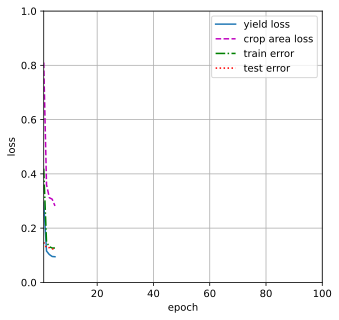

In [ ]:
if (test_env == 'guanabana'):
  best_params['num_epochs'] = 100
  y_num_id_df = combined_dfs['LABEL_NUMERIC_IDS']
  net, preds_l, preds_h, valid_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                      combined_dfs,
                                                                      country_years,
                                                                      best_params,
                                                                      is_validation=True,
                                                                      early_stopping=True,
                                                                      visualize=False)
  print('Validation NRMSE:', round(100 * valid_nrmse, 2))
  low_res_pred_cols =["id_y", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = pd.DataFrame(data=preds_l, columns=low_res_pred_cols)
  low_res_pred_df = low_res_pred_df.merge(y_num_id_df, on=["id_y"]).drop(columns=["id_y"])
  low_res_pred_cols = ["COUNTY_ID", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = low_res_pred_df[low_res_pred_cols]

  high_res_pred_df = pd.DataFrame(data=preds_h, columns=["id_y", "GRID_ID", "FYEAR", "YIELD_PRED"])
  high_res_pred_df = high_res_pred_df.merge(y_num_id_df, on=["id_y"]).drop(columns=["id_y"])
  # print(high_res_pred_df.head(5))
  yield_sel_cols = ["COUNTY_ID", "GRID_ID", "FYEAR", "YIELD"]
  high_res_pred_df = high_res_pred_df.merge(pd_grids_yield_df[yield_sel_cols], on=["COUNTY_ID", "GRID_ID", "FYEAR"])
  high_res_pred_cols = ["COUNTY_ID", "GRID_ID", "FYEAR", "YIELD_PRED", "YIELD"]
  high_res_pred_df = high_res_pred_df[high_res_pred_cols]

  valid_info = '\nValidation Set NRMSEs'
  valid_info += '\n---------------------'
  print('\n', crop)
  valid_info += '\n' + crop
  lres_nrmse = NormalizedRMSE(low_res_pred_df['YIELD'].values,
                              low_res_pred_df['YIELD_PRED'].values)
  print('\nCOUNTY level NRMSE:', lres_nrmse)
  valid_info += '\nCOUNTY Level NRMSE:' + str(lres_nrmse)
  print(low_res_pred_df.head(10))

  hres_nrmse = NormalizedRMSE(high_res_pred_df['YIELD'].values,
                              high_res_pred_df['YIELD_PRED'].values)
  print('\nGRID level NRMSE:', hres_nrmse)
  valid_info += '\nGRID level NRMSE:' + str(hres_nrmse)
  print(high_res_pred_df.head(10))

  log_fh.write(valid_info)

### Evaluate on test data

NRMSE: 0.139
Test NRMSE: 13.9

 soft wheat DE
Level y NRMSE: 11.953995914369361
  COUNTRY NUTS2_ID   FYEAR  YIELD  YIELD_PRED  CROP_AREA  CROP_AREA_PRED
0      DE     DE11  2013.0   7.56    6.966383    95312.0    63561.125000
1      DE     DE11  2014.0   8.29    7.078942    93025.0    64082.500000
2      DE     DE11  2015.0   7.73    7.142239    95852.0    67834.929688
3      DE     DE11  2016.0   6.74    7.410132    92208.0    74259.507812
4      DE     DE11  2017.0   7.60    7.439291    87077.0    74183.351562
5      DE     DE12  2013.0   6.72    6.570160    41521.0    39480.386719
6      DE     DE12  2014.0   7.32    6.646784    40525.0    39001.687500
7      DE     DE12  2015.0   6.90    6.586979    41759.0    39807.703125
8      DE     DE12  2016.0   6.17    6.825252    40170.0    44110.730469
9      DE     DE12  2017.0   6.91    6.841333    37933.0    42948.718750

Level x NRMSE: 16.616137196497395
  COUNTRY NUTS2_ID NUTS3_ID   FYEAR  YIELD  YIELD_PRED
0      DE     DE11    DE118

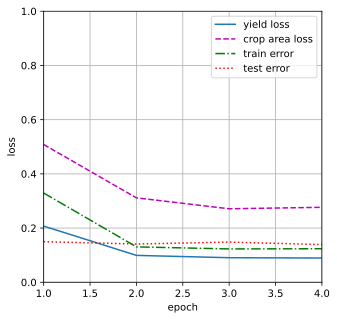

In [ ]:
if (test_env == 'guanabana'):
  y_num_id_df = combined_dfs['LABEL_NUMERIC_IDS']
  net, preds_l, preds_h, test_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                     combined_dfs,
                                                                     country_years,
                                                                     best_params,
                                                                     is_validation=False,
                                                                     early_stopping=False,
                                                                     visualize=False)
  print('Test NRMSE:', round(100 * test_nrmse, 2))
  low_res_pred_cols =["id_y", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = pd.DataFrame(data=preds_l, columns=low_res_pred_cols)

  low_res_pred_df = low_res_pred_df.merge(y_num_id_df, on=["id_y"]).drop(columns=["id_y"])
  low_res_pred_cols =["COUNTY_ID", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = low_res_pred_df[low_res_pred_cols]

  high_res_pred_df = pd.DataFrame(data=preds_h, columns=["id_y", "GRID_ID", "FYEAR", "YIELD_PRED"])
  high_res_pred_df = high_res_pred_df.merge(y_num_id_df, on=["id_y"]).drop(columns=["id_y"])
  print(high_res_pred_df.head(5))
  yield_sel_cols = ["COUNTY_ID", "GRID_ID", "FYEAR", "YIELD"]
  high_res_pred_df = high_res_pred_df.merge(pd_grids_yield_df[yield_sel_cols], on=["COUNTY_ID", "GRID_ID", "FYEAR"])
  high_res_pred_cols = ["COUNTY_ID", "GRID_ID", "FYEAR", "YIELD_PRED", "YIELD"]
  high_res_pred_df = high_res_pred_df[high_res_pred_cols]

  test_info = '\nTest Set NRMSEs'
  test_info += '\n--------------'
  print('\n', crop)
  test_info += '\n' + crop
  lres_nrmse = NormalizedRMSE(low_res_pred_df['YIELD'].values,
                              low_res_pred_df['YIELD_PRED'].values)
  print('\nCOUNTY level NRMSE:', lres_nrmse)
  test_info += '\nCOUNTY Level NRMSE:' + str(lres_nrmse)
  print(low_res_pred_df.head(10))

  hres_nrmse = NormalizedRMSE(high_res_pred_df['YIELD'].values,
                              high_res_pred_df['YIELD_PRED'].values)
  print('\nGRID Level NRMSE:', hres_nrmse)
  test_info += '\nGRID level NRMSE:' + str(hres_nrmse)
  print(high_res_pred_df.head(10))

  output_path = cyp_config['output_path']
  high_res_pred_file = getPredictionFilename(cyp_config['crop'],
                                             cyp_config['use_yield_trend'],
                                             cyp_config['early_season_end_dekad'],
                                             country=country,
                                             spatial_level=cyp_config['input_spatial_level'],
                                             architecture=cyp_config['architecture'])
  high_res_pred_df.to_csv(output_path + '/' + high_res_pred_file + '.csv', index=False)

  low_res_pred_file = getPredictionFilename(cyp_config['crop'],
                                            cyp_config['use_yield_trend'],
                                            cyp_config['early_season_end_dekad'],
                                            country=country,
                                            spatial_level=cyp_config['label_spatial_level'],
                                            architecture=cyp_config['architecture'])

  low_res_pred_df.to_csv(output_path + '/' + low_res_pred_file + '.csv', index=False)

  log_fh.write(test_info)

### Evaluate Multiple Runs

#### Datasets

In [ ]:
test_fraction = cyp_config['test_fraction']
use_yield_trend = cyp_config['use_yield_trend']
early_season_end = cyp_config['early_season_end_dekad']
print_debug = cyp_config['debug_level'] > 1
num_valid_years = 5

scaler_args = {}
train_dataset = CYPMLDataset(combined_dfs, country_years,
                             yield_trend=use_yield_trend,
                             early_season_end=early_season_end,
                             is_train=True,
                             test_fraction=test_fraction,
                             num_folds=1, fold_iter=0,
                             num_valid_years=num_valid_years,
                             scaler_args=scaler_args,
                             print_debug=print_debug,
                             log_fh=log_fh)

valid_dataset = CYPMLDataset(combined_dfs, country_years,
                             yield_trend=use_yield_trend,
                             early_season_end=early_season_end,
                             is_train=False, is_validation=True,
                             test_fraction=test_fraction,
                             num_folds=1, fold_iter=0,
                             num_valid_years=num_valid_years,
                             scaler_args=scaler_args,
                             print_debug=print_debug,
                             log_fh=log_fh)

scaler_args = {}
train_dataset2 = CYPMLDataset(combined_dfs, country_years,
                              yield_trend=use_yield_trend,
                              early_season_end=early_season_end,
                              is_train=True,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=0,
                              scaler_args=scaler_args,
                              print_debug=print_debug,
                              log_fh=log_fh)

test_dataset = CYPMLDataset(combined_dfs, country_years,
                            yield_trend=use_yield_trend,
                            early_season_end=early_season_end,
                            is_train=False, is_validation=False,
                            test_fraction=test_fraction,
                            num_folds=1, fold_iter=0,
                            num_valid_years=0,
                            scaler_args=scaler_args,
                            print_debug=print_debug,
                            log_fh=log_fh)

datasets = {
    'valid' : [train_dataset, valid_dataset],
    'test' : [train_dataset2, test_dataset]
}


----------------
Training data
----------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, TWC, RSM, TMAX, TMIN, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA90, CN_0, CN_1, CN_2, CN_3, AEZ_1761, AEZ_1810, AEZ_1842, AEZ_1845, AEZ_1892, AEZ_1932, AEZ_1957, AEZ_1960, AEZ_1976, AEZ_1984, AEZ_2030, AEZ_2034, AEZ_2057, AEZ_2075, AEZ_2107, AEZ_2135, AEZ_2137, AEZ_2150
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD, CROP_AREA

DE Training years: 2004, 2005, 2006, 2007

ES Training years: 2003, 2004, 2005, 2006

FR Training years: 1999, 2000, 2001, 2002, 2003, 2004, 2005

IT Training years: 2000, 2001, 2002, 2003, 2004, 2005, 2006


Dekadal data: 1882, 30, 14
Other feature data: 357, 33
Trend feature data: 435, 5
Label data: 435, 5

------------------
Validation data
------------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, TWC, RSM, TMAX, TMIN, TAVG, P

#### Training and Evaluation

In [ ]:
def trainAndTest(cyp_config, best_params,
                 train_dataset, test_dataset,
                 early_stopping=False,
                 visualize=False, country=None):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                             shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                            shuffle=False, num_workers=2)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend.
  # X_rest shape is (num_regions, variables). Skip TOTAL_AREA
  train_data_item = train_dataset[0]
  num_other_features = train_data_item[1].shape[1] - 1

  # X_trend shape is (trend_window)
  num_trend_features = train_data_item[2].shape[0]

  # time series (dekadal) data is [num_regions, num_dekads, num_indicators]
  num_ts_indicators = train_data_item[0].shape[2]
  ts_seq_len = train_data_item[0].shape[1]

  device = d2l.try_gpu()
  net = CYPLSTMModel(num_ts_indicators,
                     num_trend_features,
                     num_other_features,
                     ts_seq_len=ts_seq_len,
                     num_outputs=2)

  net = net.to(device)
  # need to handle 64 bit values
  net.double()
  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_dataset, train_loader, test_loader,
                                 loss, best_params['loss_split'],
                                 trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  preds_l, preds_h, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, preds_h, preds_l, test_nrmse

#### Evaluate Multiple Runs

In [ ]:
import pandas as pd
import statistics as stat

num_iters = 10
valid_set_lres_nrmses = []
valid_set_hres_nrmses = []
test_set_lres_nrmses = []
test_set_hres_nrmses = []

for i in range(1, num_iters + 1):
  """
  Evaluate on validation data with early stopping
  """
  iter_info = '\n' + 'Iteration ' + str(i)
  iter_info += '\n-------------------'
  print(iter_info)
  log_fh.write(iter_info)

  best_params['num_epochs'] = 100
  valid_info = '\n\nValidation Set Evaluation'
  valid_info += '\n----------------------------'
  print(valid_info)

  y_num_id_df = combined_dfs['LABEL_NUMERIC_IDS']
  net, preds_h, preds_l, valid_nrmse = trainAndTest(cyp_config, best_params,
                                                    datasets['valid'][0], datasets['valid'][1],
                                                    early_stopping=True, visualize=False, country=country)

  valid_info = '\nValidation NRMSE:' + str(round(100 * valid_nrmse, 3))
  low_res_pred_cols =["id_y", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  pd_lres_cv_preds = pd.DataFrame(data=preds_l, columns=low_res_pred_cols)
  pd_lres_cv_preds = pd_lres_cv_preds.merge(y_num_id_df, on=["id_y"]).drop(columns=["id_y"])
  low_res_pred_cols = ["COUNTY_ID", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  pd_lres_cv_preds = pd_lres_cv_preds[low_res_pred_cols]

  pd_hres_cv_preds = pd.DataFrame(data=preds_h, columns=["id_y", "GRID_ID", "FYEAR", "YIELD_PRED"])
  pd_hres_cv_preds = pd_hres_cv_preds.merge(y_num_id_df, on=["id_y"]).drop(columns=["id_y"])
  yield_sel_cols = ["COUNTY_ID", "GRID_ID", "FYEAR", "YIELD"]
  pd_hres_cv_preds = pd_hres_cv_preds.merge(pd_grids_yield_df[yield_sel_cols], on=["COUNTY_ID", "GRID_ID", "FYEAR"])
  high_res_pred_cols = ["COUNTY_ID", "GRID_ID", "FYEAR", "YIELD_PRED", "YIELD"]
  pd_hres_cv_preds = pd_hres_cv_preds[high_res_pred_cols]

  valid_info += '\nValidation Set NRMSEs'
  valid_info += '\n---------------------'
  valid_info += '\n' + crop + '(US)'
  lres_nrmse = NormalizedRMSE(pd_lres_cv_preds['YIELD'].values,
                              pd_lres_cv_preds['YIELD_PRED'].values)
  # print('Level y NRMSE:', lres_nrmse)
  valid_info += '\nLevel y NRMSE:' + str(lres_nrmse)
  valid_set_lres_nrmses.append(lres_nrmse)

  hres_nrmse = NormalizedRMSE(pd_hres_cv_preds['YIELD'].values,
                              pd_hres_cv_preds['YIELD_PRED'].values)
  # print('\nLevel x NRMSE:', hres_nrmse)
  valid_info += '\nLevel x NRMSE:' + str(hres_nrmse)
  valid_set_hres_nrmses.append(hres_nrmse)

  print(valid_info)
  log_fh.write(valid_info)

  """
  Evaluate on test data with early stopping epochs from above
  """
  test_info = '\n\nTest Set Evaluation'
  test_info += '\n----------------------------'
  print(test_info)
  net, preds_h, preds_l, test_nrmse = trainAndTest(cyp_config, best_params,
                                                   datasets['test'][0], datasets['test'][1],
                                                   early_stopping=False, visualize=False, country=country)
  test_info = '\nTest NRMSE: ' + str(round(100 * test_nrmse, 2))
  low_res_pred_cols =["id_y", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  pd_lres_test_preds = pd.DataFrame(data=preds_l, columns=low_res_pred_cols)
  pd_lres_test_preds = pd_lres_test_preds.merge(y_num_id_df, on=["id_y"]).drop(columns=["id_y"])
  low_res_pred_cols = ["COUNTY_ID", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  pd_lres_test_preds = pd_lres_test_preds[low_res_pred_cols]

  pd_hres_test_preds = pd.DataFrame(data=preds_h, columns=["id_y", "GRID_ID", "FYEAR", "YIELD_PRED"])
  pd_hres_test_preds = pd_hres_test_preds.merge(y_num_id_df, on=["id_y"]).drop(columns=["id_y"])
  yield_sel_cols = ["COUNTY_ID", "GRID_ID", "FYEAR", "YIELD"]
  pd_hres_test_preds = pd_hres_test_preds.merge(pd_grids_yield_df[yield_sel_cols], on=["COUNTY_ID", "GRID_ID", "FYEAR"])
  high_res_pred_cols = ["COUNTY_ID", "GRID_ID", "FYEAR", "YIELD_PRED", "YIELD"]
  pd_hres_test_preds = pd_hres_test_preds[high_res_pred_cols]

  test_info += '\nTest Set NRMSEs'
  test_info += '\n---------------------'
  test_info += '\n' + crop + '(US)'
  lres_nrmse = NormalizedRMSE(pd_lres_test_preds['YIELD'].values,
                              pd_lres_test_preds['YIELD_PRED'].values)
  # print('Level y NRMSE:', lres_nrmse)
  test_info += '\nLevel y NRMSE:' + str(lres_nrmse)
  test_set_lres_nrmses.append(lres_nrmse)

  hres_nrmse = NormalizedRMSE(pd_hres_test_preds['YIELD'].values,
                              pd_hres_test_preds['YIELD_PRED'].values)
  # print('\nLevel x NRMSE:', hres_nrmse)
  test_info += '\nLevel x NRMSE:' + str(hres_nrmse)
  test_set_hres_nrmses.append(hres_nrmse)

  print(test_info)
  log_fh.write(test_info)

  output_path = cyp_config['output_path']
  high_res_pred_file = getPredictionFilename(cyp_config['crop'],
                                             cyp_config['use_yield_trend'],
                                             cyp_config['early_season_end_dekad'],
                                             country=country,
                                             spatial_level=cyp_config['input_spatial_level'],
                                             architecture=cyp_config['architecture'])
  pd_hres_test_preds.to_csv(output_path + '/' + high_res_pred_file + '-' + str(i) + '.csv', index=False)

  low_res_pred_file = getPredictionFilename(cyp_config['crop'],
                                            cyp_config['use_yield_trend'],
                                            cyp_config['early_season_end_dekad'],
                                            country=country,
                                            spatial_level=cyp_config['label_spatial_level'],
                                            architecture=cyp_config['architecture'])

  pd_lres_test_preds.to_csv(output_path + '/' + low_res_pred_file + '-' + str(i) + '.csv', index=False)

valid_info = '\n\nAverage Validation Set NRMSEs'
valid_info += '\n----------------------------'
avg_lres_nrmse = round(stat.fmean(valid_set_lres_nrmses), 3)
avg_hres_nrmse = round(stat.fmean(valid_set_hres_nrmses), 3)
valid_info += '\n' + crop + ', US' + '(' + cyp_config['label_spatial_level'] + '): ' + str(avg_lres_nrmse)
valid_info += '\n' + crop + ', US' + '(' + cyp_config['input_spatial_level'] + '): ' + str(avg_hres_nrmse)

print(valid_info)
log_fh.write(valid_info)

test_info = '\n\nAverage Test Set NRMSEs'
test_info += '\n----------------------------'
avg_lres_nrmse = round(stat.fmean(test_set_lres_nrmses), 3)
avg_hres_nrmse = round(stat.fmean(test_set_hres_nrmses), 3)
test_info += '\n' + crop + ', US' + '(' + cyp_config['label_spatial_level'] + '): ' + str(avg_lres_nrmse)
test_info += '\n' + crop + ', US' + '(' + cyp_config['input_spatial_level'] + '): ' + str(avg_hres_nrmse)

log_fh.write(test_info)
print(test_info)


Iteration 1
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.1239

Validation NRMSE:12.387
Validation Set NRMSEs
---------------------
soft wheat(DE)
Level y NRMSE:11.488287114440771
Level x NRMSE:16.944089684724634
soft wheat(ES)
Level y NRMSE:19.862470036245934
Level x NRMSE:25.123044320128535
soft wheat(FR)
Level y NRMSE:8.858372623890096
Level x NRMSE:12.368027989192736
soft wheat(IT)
Level y NRMSE:17.244108212384308
Level x NRMSE:20.548790127574037


Test Set Evaluation
----------------------------
NRMSE: 0.1409

Test NRMSE: 14.09
Test Set NRMSEs
---------------------
soft wheat(DE)
Level y NRMSE:11.963050746974794
Level x NRMSE:16.674813867559674
soft wheat(ES)
Level y NRMSE:22.037348141150034
Level x NRMSE:31.32366227177441
soft wheat(FR)
Level y NRMSE:12.752690072439652
Level x NRMSE:15.349041660868911
soft wheat(IT)
Level y NRMSE:18.441620323779635
Level x NRMSE:20.96797247080136

Iteration 2
-------------------


Validation Set Evaluation

### Close file handle

In [ ]:
log_fh.close()